In [1]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import IBMQ
from qiskit.backends.ibmq import least_busy
from qiskit.wrapper.jupyter import *
from qiskit.tools.visualization import plot_histogram, circuit_drawer
import numpy as np

In [2]:
import os
import dotenv
dotenv.load_dotenv('.env')
API_TOKEN = os.environ.get("IBMQ_API_TOKEN")
IBMQ.enable_account(API_TOKEN)

# グローバー・アルゴリズムを実装
## 2量子ビットで解が01の場合の回路

In [3]:
q = QuantumRegister(3)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
qc.x(q[2])
qc.h(q)

# 解=01のときのグローバー回路
## 反転演算子I_x0 (解が01なので、0に対応する2ビット名だけ反転させる)
qc.x(q[1])
qc.ccx(q[0],q[1],q[2])
qc.x(q[1])
## 拡散演算子D
qc.h(q)
qc.x(q)
qc.cz(q[0],q[1])
qc.x(q)
qc.h(q)

qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

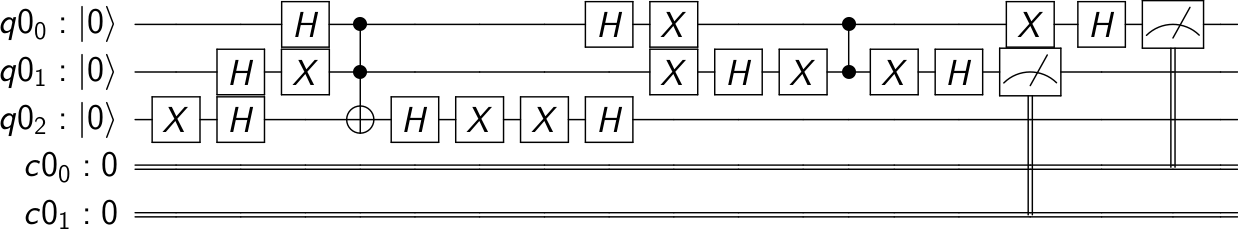

In [4]:
circuit_drawer(qc)

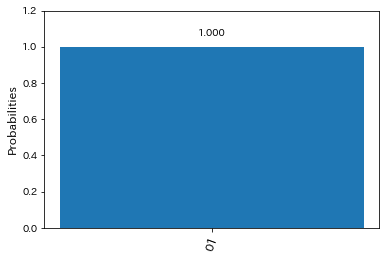

In [5]:
backend = least_busy(IBMQ.backends(simulator=True))
result = execute(qc, backend=backend).result()
plot_histogram(result.get_counts())

解の01が求められた

## 一般化
n量子ビットの任意解に対する回路を生成するクラスを実装する
* 下記課題の通り、現状ではn=2でしか動作しない

### 課題
#### 反転演算子のところでn+1量子ビットに対する制御NOTゲートが必要なので、n=2のときトフォリゲートが使えるが、n>2の場合に動的にゲートを生成する必要がある。

↓これを組み込めばいけそう。
* https://quantumcomputing.stackexchange.com/questions/2177/how-can-i-implement-an-n-bit-toffoli-gate

#### 拡散演算子のところでもn量子ビットに対する制御Zゲートが必要なので、n>2の場合に動的にゲートを生成する必要がある。

In [6]:
class GloverSearch:
    """
    グローバー・アルゴリズムの量子回路を作成するクラス
    n: 量子ビット数
    answer: 解(二進数文字列で指定. 例:'110')
    """
    def __init__(self, n, answer):
        self.n = n
        self.answer = answer
        self.q = QuantumRegister(n+1, 'q') # 量子オラクル用に1ビット余計に確保
        self.c = ClassicalRegister(n, 'c')
        self.qc = QuantumCircuit(self.q, self.c)
    
    def execute(self, simulator=True):
        """
        グローバー・アルゴリズムを適用する
        simulator: シミュレータを使う場合はTrue
        """
        qc, q, c, n = self.qc, self.q, self.c, self.n
        # 入力値初期化(入力は全て|0>で量子オラクル用に|1>を追加しアダマール変換したもの)
        qc.x(q[n]) # 量子オラクル用のビットを|1>にするためビット反転
        qc.h(q)
        
        # グローバー演算子Gをk回適用する
        k = int(np.floor(np.pi * np.sqrt(self.n) / 4)) # k = ⌊ π/4 * √n ⌋ 
        [self.__G() for _ in range(k)]

        # 計測
        [qc.measure(q[i], c[i]) for i in range(n)]
                    
        # 実行
        backend = least_busy(IBMQ.backends(simulator=simulator))
        self.result = execute(qc, backend=backend).result()
        return self.result
    
    def circuit_drawer(self):
        """回路図を描画する"""
        return circuit_drawer(self.qc)
        
    def plot_histogram(self):
        """ヒストグラムを描画する"""
        return plot_histogram(self.result.get_counts())
        
    def __G(self):
        """グローバー演算子Gを適用する"""
        self.__Ix0()
        self.__D()
        
    def __Ix0(self):
        """反転演算子I_x0を適用する"""
        qc, q, c, n, answer = self.qc, self.q, self.c, self.n, self.answer
        # answerの"0"に対応するビットだけ反転する処理をlambdaで実装
        invert_zero_bits = lambda answer: [qc.x(q[i]) for i in self.find_zero_bits(answer)]
            
        invert_zero_bits(answer)
        qc.ccx(q[0], q[1], q[2]) #TODO: n+1量子ビットの制御NOTゲートがないと一般化できない★
        invert_zero_bits(answer)
    
    @staticmethod
    def find_zero_bits(binstr):
        """
        二進数文字列の0に対応する桁の量子ビットのインデックスを返す。
        量子ビットは二進数文字列の桁数の順番が逆になるので注意。
        例1: '01'  => [1]
        例2: '100' => [0, 1]
        """
        bin_array = np.array(list(binstr))
        bin_array = bin_array[::-1] # リストを逆順にする
        ret, = np.where(bin_array == '0')
        return ret.tolist()
        
    def __D(self):
        """拡散演算子Dを適用する"""
        qc, q, c, n = self.qc, self.q, self.c, self.n
        
        qc.h(q)
        qc.x(q)
        qc.cz(q[0], q[1]) #TODO: n量子ビットの制御Zゲートがないと一般化できない★
        qc.x(q)
        qc.h(q)

### 解が'00'の場合

In [7]:
gs2_00 = GloverSearch(2, '00')
gs2_00.execute()

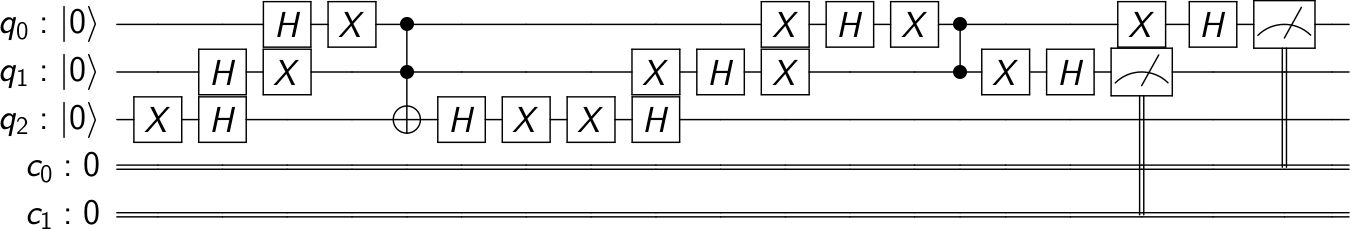

In [8]:
gs2_00.circuit_drawer()

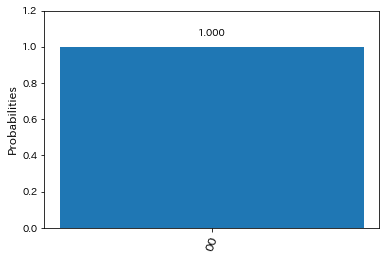

In [9]:
gs2_00.plot_histogram()

解の'00'が求められた

### 解が'01'の場合

In [10]:
gs2_01 = GloverSearch(2, '01')
gs2_01.execute()

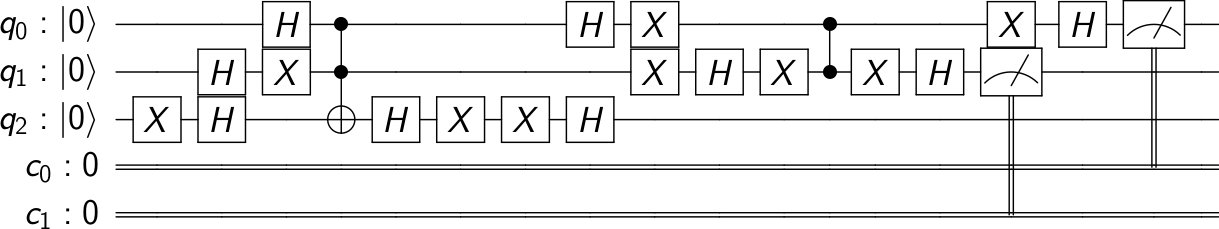

In [11]:
gs2_01.circuit_drawer()

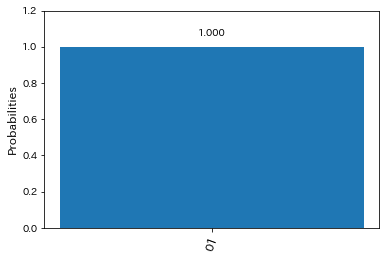

In [12]:
gs2_01.plot_histogram()

解の01が求められた

In [13]:
ret = GloverSearch.find_zero_bits('00')